In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Patch to remove log values from the colorbar on the hexbin plot
from matplotlib.ticker import LogFormatter 
class LogFormatterHB(LogFormatter):
     def __call__(self, v, pos=None):
         vv = self._base ** v
         return LogFormatter.__call__(self, vv, pos) 

# Convert latitude, longitude pairs to distance in meters
def pythagoras(lat_in, lon_in):
    lat = np.array(lat_in)
    lon = np.array(lon_in)
    
    lat *= np.pi/180
    lon *= np.pi/180
    
    lon1 = lon[0:-1]
    lon2 = lon[1:]
    
    lat1 = lat[0:-1]
    lat2 = lat[1:]
    
    x = (lon2-lon1) * np.cos((lat1+lat2)/2)
    y = lat2-lat1
    
    d = np.sqrt(x**2 + y**2) * 6371*1000
    return d


# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files

In [5]:
#%% Read in data 

#full_files = ['data/012/15.txt']        # 1 file:      50 KB
#full_files = get_files('data/012')      # 1 folder:    30-50 MB
full_files = get_files(r"D:\taxi_log_2008_by_id")           # All folders: 700 MB

print("Reading i n741 the .txt files...")

data = []
for index, file_path in enumerate(full_files):
    data.append(pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude']))

data = pd.concat(data, ignore_index=True)

print("Size of data frame: ", data.shape)
print("%.1f million rows" % (data.shape[0]/1.0e6))

# Drop duplicates and NAs 
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

Reading in the .txt files...
Size of data frame:  (17662984, 4)
17.7 million rows


In [13]:
#%% Compute Time Intervals
print( "Computing time intervals...")
grouped = data.sort_values('date_time').groupby('taxi_id')['date_time']

time_intervals = []
for group_id, times in grouped:
#    times.sort(inplace=True)
    time_intervals.append(times.diff())
    
time_intervals = pd.concat(time_intervals)
time_intervals.dropna(inplace=True)
time_intervals /= np.timedelta64(1,'s') # Divide by 1 second, for float64 data


print("Average sample interval: %.0f secs" % time_intervals[time_intervals < 1e4].mean()) 
time_intervals /= 60    # Convert to minutes

Computing time intervals...
Average sample interval: 220 secs


Plotting position density...


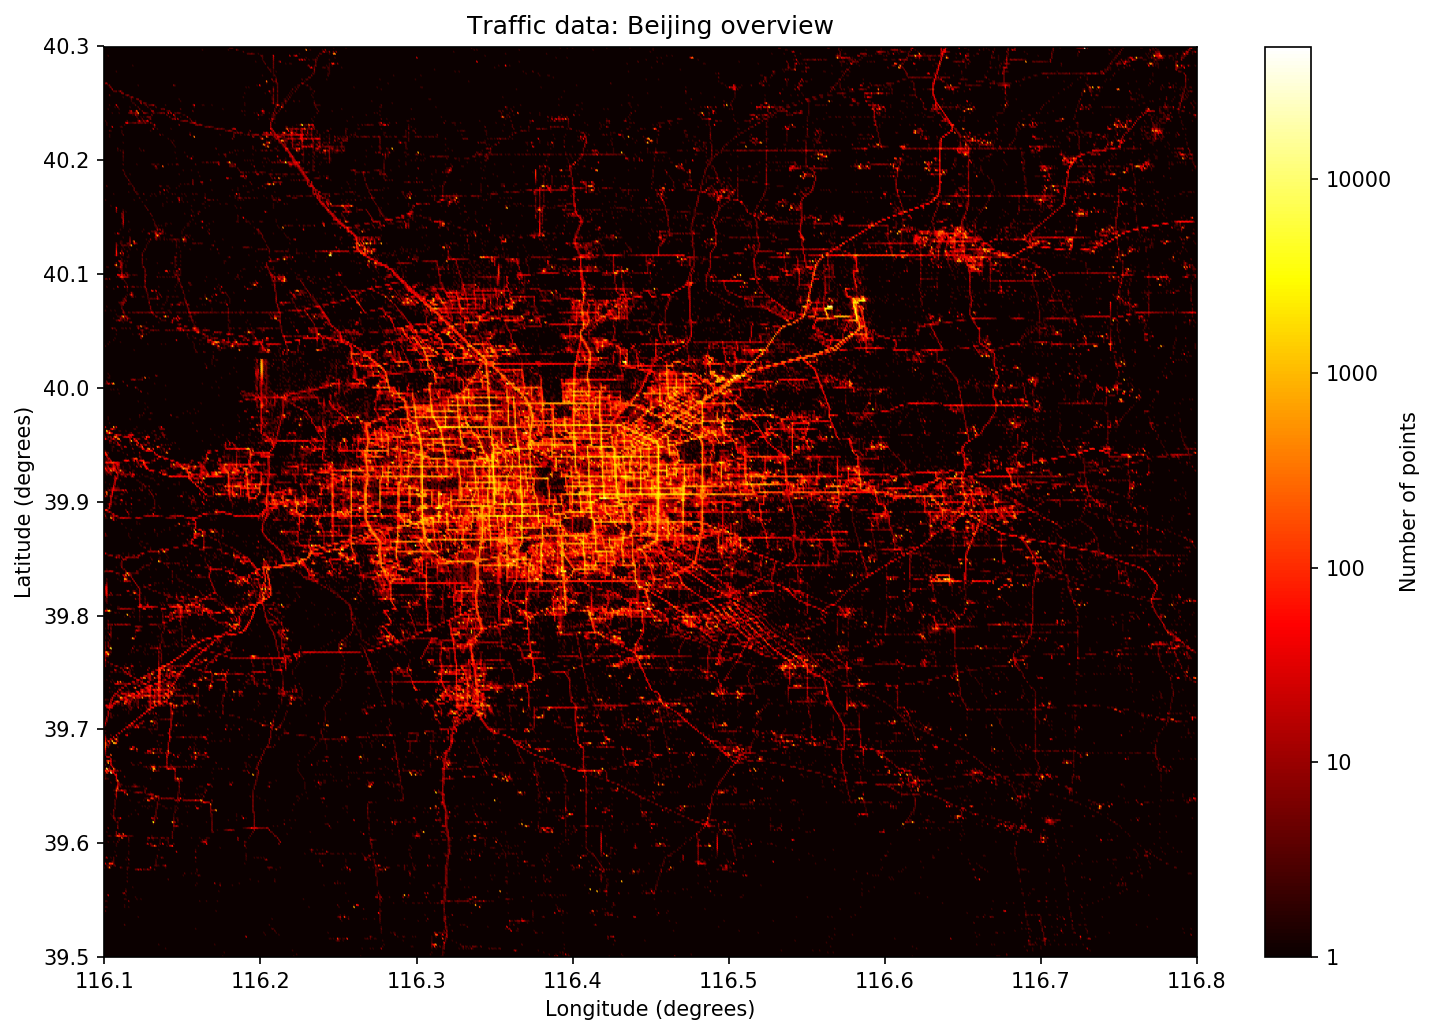

In [15]:
#%% Plot position density -- Overview 

print("Plotting position density...")
xmin, xmax = 116.1, 116.8
ymin, ymax = 39.5, 40.3

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data: Beijing overview")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

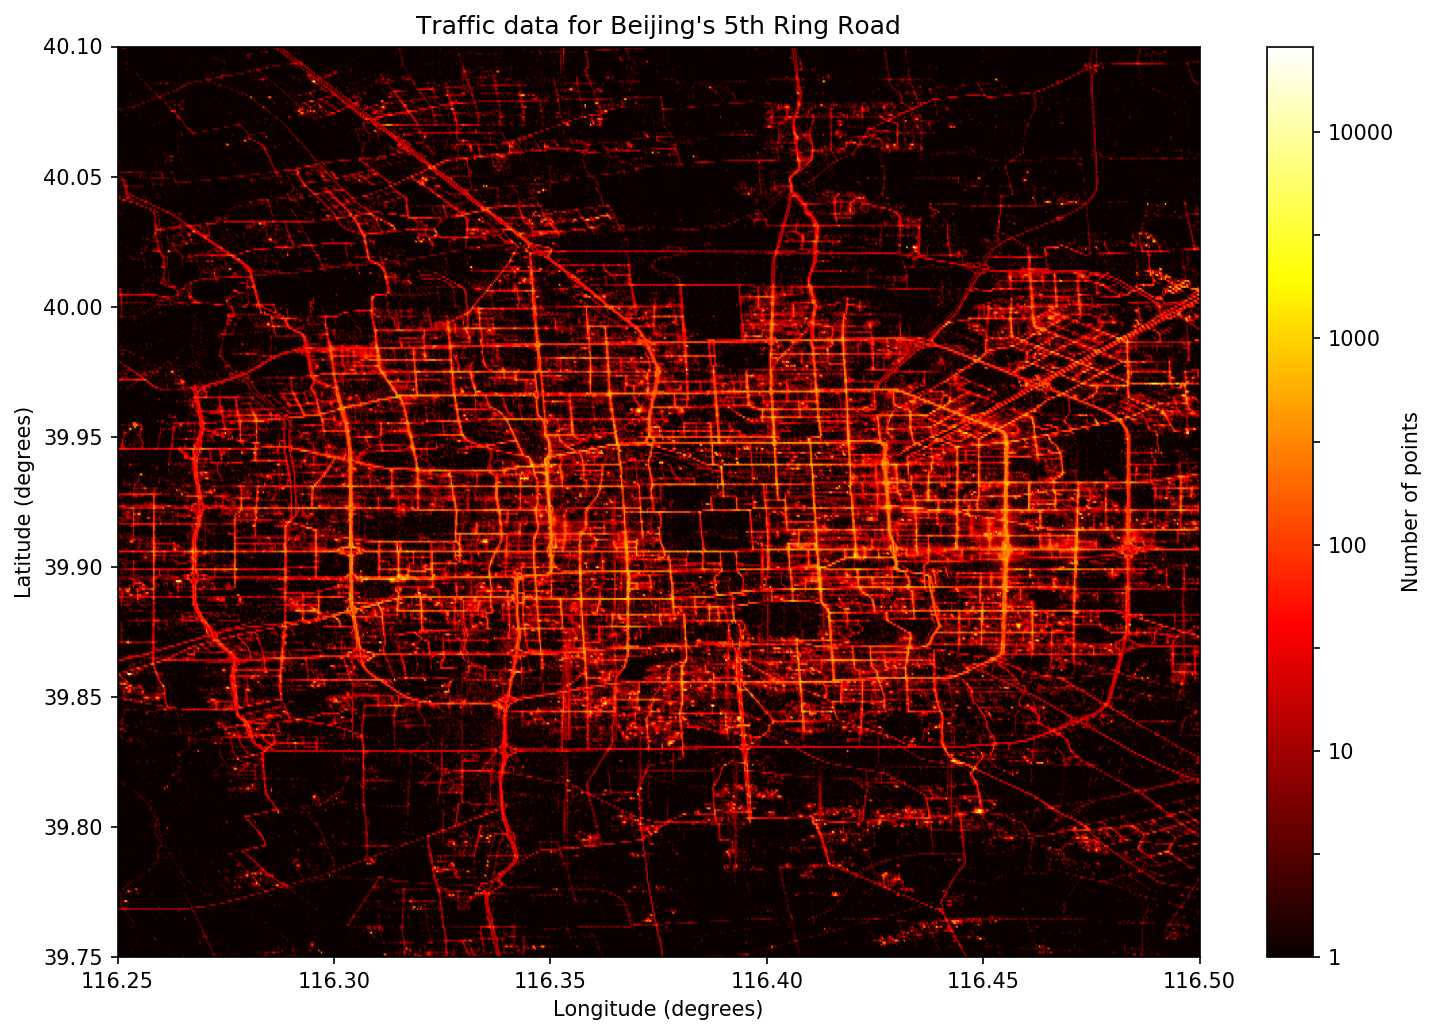

In [6]:

# Location details
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data for Beijing's 5th Ring Road")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()